# Blahut-Arimoto algorithm to compute the channel capacity for a given input-output response.

In [1]:
# Our numerical workhorses
import numpy as np
from sympy import mpmath
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd
import itertools
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Pickle is useful for saving outputs that are computationally expensive
# to obtain every time
import pickle

import os
import glob

# Import the utils for this project
import chann_cap_utils as chann_cap

chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/blahut_algorithm_channel_capacity/'
tmpdir = '../../tmp/'

# Input probability that maximizes the information transmited through a channel $P(m \mid C)$

Given the symmetry in the mutual information, i.e. $I(m;C)=I(C;m)$ the problem of transmiting a message can be studied from two perspectives:
1. Given a **fix input** $P(C)$ what is the input-output response $P(m \mid C)$ that would minimize the information subject to some average distortion $D$.
2. Given a **fix channel** $P(m \mid C)$ what is the input distribution that would maximize the mutual information.

The first view is treated by rate-distortion theory. The second point is the problem of computing the so-called information capacity of a channel. This information capacity is defined as
\begin{equation}
    C \equiv \max_{P(C)} I(C;m),
\end{equation}
where the maximum is taken over the space of probabilities $P(C)$. This means that a probability distribution $P^*(C)$ achieves capacity if it maximizes the information that can be transmitted through a fix channel.

This second view brings interesting points for our theory. On the one hand we are trying to evolve/design a circuit which could respond given a distribution of inputs. For this case rate-distortion theory tells us the minimum amount of information the channel should transmit from the input to maintain an average growth rate. On the other hand we have the full theoretical input-output function response for a given set of parameters. In this case it would be interesting to find which distribution of inputs would maximize the mutual information, and what would that maximum mutual information value be.

Luckly for us in his elegant paper Blahut not only developed the rate-distortion algorithm we implemented previously, but he also showed a simple iterataive algorithm that can approximate the distribution of inputs that achieves capacity.

In this script we will implement such algorithm and compute the maximum mutual information one can transmit through a simple repression circuit!

# Testing the implementation of the algorithm.

Before going all in with the implementation of the algorithm is worth testing it with a simple example.

We will test the regular Blahut-Arimoto (BA) algorithm as well as the accelerated BA algorithm from Matz and Duhamel 2005.

Let's implement the BA first.

In [2]:
def channel_capacity(QmC, epsilon=1E-3, info=1E4):
    '''
    Performs the Blahut-Arimoto algorithm to compute the channel capacity
    given a channel QmC.

    Parameters
    ----------
    QmC : array-like 
        definition of the channel with C inputs and m outputs.
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    info : int.
        Number indicating every how many cycles to print the cycle number as
        a visual output of the algorithm.
    Returns
    -------
    C : float.
        channel capacity, or the maximum information it can be transmitted 
        given the input-output function.
    pc : array-like.
        array containing the discrete probability distribution for the input 
        that maximizes the channel capacity
    '''
    # initialize the probability for the input.
    pC = np.repeat(1 / QmC.shape[0], QmC.shape[0])
        
    # Initialize variable that will serve as termination criteria
    Iu_Il = 1
    
    loop_count = 0
    # Perform a while loop until the stopping criteria is reached
    while Iu_Il > epsilon:
        if (loop_count % info == 0) & (loop_count != 0):
            print('loop : {0:d}, Iu - Il : {1:f}'.format(loop_count, Iu_Il))
        loop_count += 1
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # cC = exp(∑_m Qm|C log(Qm|C / ∑_c pC Qm|C))
        sum_C_pC_QmC = np.sum((pC * QmC.T).T, axis=0)
        QmC_log_QmC_sum_C_pC_QmC = QmC * np.log(QmC / sum_C_pC_QmC)
        # check for values that go to -inf because of 0xlog0
        QmC_log_QmC_sum_C_pC_QmC[np.isnan(QmC_log_QmC_sum_C_pC_QmC)] = 0
        QmC_log_QmC_sum_C_pC_QmC[np.isneginf(QmC_log_QmC_sum_C_pC_QmC)] = 0
        cC = np.exp(np.sum(QmC_log_QmC_sum_C_pC_QmC, axis=1))
       
        # I_L log(∑_C pC cC)
        Il = np.log(np.sum(pC * cC))
        
        # I_U = log(max_C cC)
        Iu = np.log(cC.max())
        
        # pC = pC * cC / ∑_C pC * cC
        pC = pC * cC / np.sum(pC * cC)
        
        Iu_Il = Iu - Il
        
    # convert from nats to bits
    Il = Il / np.log(2)
    return Il, pC, loop_count

Let's test the algorithm with the exercise that Matz proposes in his paper.

In [3]:
QmC = np.array([[0.7, 0.1], [0.2, 0.2], [0.1, 0.7]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.36514844544
Input distribution: [ 0.5  0.5]
Iterations: 1


Now the channel that Arimoto proposes in his paper

In [3]:
QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05], [0.1, 0.2, 0.45]])

Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il)
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 0.161631860824
Input distribution: [  5.01735450e-01   1.41574430e-09   4.98264548e-01]
Iterations: 305


The algorithm converges to the value reported on the paper. So we know that this implementation is working.


## Blahut-Arimoto algorithm for channel capacity.

Again the approach that we will take to implement this algorithm would be to discretize our input distribution, i.e. $P(C) \approx \mathbf{p}_C$ and also we will discretize the input-output response $P(m \mid C) \approx \mathbf{Q}$.

In the paper (and in my notes) it is shown how this iterative algorithm converges to the channel capacity.

Let's go ahead and implement the algorithm.

In [3]:
def trans_matrix(C, m, logPmC_fun, param, tol=0.01,
                 spline=False, verbose=False):
    '''
    Computes the transition matrix P(m|C) for a promoter given a series of 
    concentrations C and molecules (either mRNA or protein) where the transition 
    matrix is  built according to the logPmC_fun.
    The function can take the spline approximation to the logPmC_fun. If so the
    param dictionary should include the step and tol parameters for this function.
    
    IMPORTANT : We have noticed that for some high repressor copy numbers the 
    calculation at high repressor copy number diverges. This problem is solved
    by taking a smaller range of proteins in the calculation. That's why the 
    function automatically checks that the distributions are normalized, and
    corrects for the ones that are not.

    Parameters
    ----------
    C : array-like.
        Concentration discretized values that are used to compute the
        distributions. logC is assumed to be uniform over the log of the
        values given in the array.
    m : array-like.
        molecule (either mRNA or protein) copy number per cell.
    logPmC_fun : function.
        Function to determine the conditional distribution logP(m|C). This in
        general will be one of the versions of the chemical master equation
        solutions, but it can be extended to any input-outpu function one
        wants to use.
        NOTE: When applied to C and m it must return an array of the same
        length.
    param : dictionary.
        Dictionary containing the parameters for the function that computes
        the probability P(m|C). Look for the help on the specific logPmC_fun
        used to know the list of parameters required.
    epsilon : float.
        Error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    info : int.
        Number to indicate every how many steps to print the step that
        the algorithm is running.
    tol : float.
        +- Tolerance allowed for the normalization. The distribution is considered
        normalized if it is within 1+-tol
    spline : bool.
        Indicate ff the function used to compute the probability uses the 
        spline fitting approximation.
        NOTE : if this is the case the m array should be length 2 with the min
        and the max of the range to be used and the param dictionary should 
        contain an entry step for the step size.
    verbose : bool.
        Print the concentrations which distributions are being calculated at
        the moment or not.
    Returns
    -------
    Chan_cap : float.
        Channel capacity, or the maximum information it can be transmitted 
        given the input-output function.
    pc : array-like.
        Array containing the discrete probability distribution for the input 
        that maximizes the channel capacity
    '''
    # Check if the spline approximation is called
    if spline:
        param['tol'] = tol
        # Since we'll need 2D integrals, make a mesh of variables
        CC, mm = np.meshgrid(C, np.arange(m[0], m[1]))
        # initialize the matrix to save the probabilities
        QmC = np.zeros_like(CC)
        # Loop through the concentrations
        for i, c in enumerate(C):
            if verbose:
                print('C = {:f}'.format(c))
            # Build P(m|C) the input-output transition matrix
            prob = np.exp(logPmC_fun(c, m, **param))
            # Check that the distribution is normalized, otherwise perform
            # the calculation using a smaller range of m molecules to evaluate
            # since this solves the numerical problem that high number of 
            # repressor copy numbers tend to have.
            if (np.sum(prob) <= 1 + tol) & (np.sum(prob) >= 1 - tol):
                QmC[:, i] = prob
            else:
                print('Dist not normalized, re-computing with smaller range.')
                # If not normalize compute up to 1/3 of the original range
                mnew = np.floor(m[1] / 3)
                QmC[m[0]:mnew, i] = np.exp(logPmC_fun(c, [m[0], mnew], **param))
        
    # If not spline approximation is called perform the regular computation
    # But also checking that the distribution is normalized
    else:
        # Since we'll need 2D integrals, make a mesh of variables
        CC, mm = np.meshgrid(C, m)
        # Build P(m|C) the input-output transition matrix
        # Initialize the matrix
        QmC = np.zeros_like(CC)
        for i, c in enumerate(C):
            if verbose:
                print('C = {:f}'.format(c))
            # Build P(m|C) the input-output transition matrix
            prob = np.exp(logPmC_fun(c, m, **param))
            # Check that the distribution is normalized, otherwise perform
            # the calculation using a smaller range of m molecules to evaluate
            # since this solves the numerical problem that high number of 
            # repressor copy numbers tend to have.
            if (np.sum(prob) <= 1 + tol) & (np.sum(prob) >= 1 - tol):
                QmC[:, i] = prob
            else:
                print('Dist not normalized, re-computing with smaller range.')
                # If not normalize compute up to 1/3 of the original range
                mnew = np.floor(m[-1] / 3)
                QmC[m[0]:mnew, i] = np.exp(logPmC_fun(c, np.arange(m[0], mnew), 
                                                      **param))
                
    return QmC

# Compute the channel capacity for all 3 operators

Let's compute the channel capacity for all of the operators.

To speed up the calculations we will use only the 12 concentrations of IPTG we use experimentally.

Let's first define the parameters for both the mRNA and the protein distributions

## channel capacity at the mRNA level

In [27]:
# Specify some parameters
k0 = 2.7E-3
mRNA_params = dict(ka=0.21, ki=0.00087, omega=np.exp(-4.5), 
                   kon=chann_cap.kon_fn(-13.9),
                   k0=k0, gamma=0.00284, r_gamma=15.7)

In [12]:
# New set of parameters where k0 was fit to the O2 RBS1027 0uMIPTG data
mRNA_params = {'gamma': 0.00284,
         'k0': 0.0000023,
         'ka': 0.199,
         'ki': 0.00064,
         'omega': np.exp(-4.5),
         'r_gamma': 15.7}

In [13]:
# Define the concentrations to evaluate
C_grid = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

# Define the mRNA copy numbers to evaluate
mRNA_grid = np.arange(0, 40)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(1, 3, 70)

kon_array = [chann_cap.kon_fn(-17, mRNA_params['k0']),
             chann_cap.kon_fn(-15.3, mRNA_params['k0']),
             chann_cap.kon_fn(-13.9, mRNA_params['k0']),
             chann_cap.kon_fn(-9.7, mRNA_params['k0'])]
kon_operators = ['Oid', 'O1', 'O2', 'O3']

compute_capacity = True
df_chan_cap = pd.DataFrame()
if compute_capacity:
    for i, kon in enumerate(kon_array):
    # define a function to run in parallel the computation
        def capacity_parallel(r):
            mRNA_params['rep'] = r
            mRNA_params['kon'] = kon
            QmC = trans_matrix(C=C_grid, 
                                m=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_C,
                                param=mRNA_params)
            return channel_capacity(QmC.T)[0]
        # Perform the parallel computation
        chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) \
                                        for r in R_array)
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([chan_cap, R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in mRNA_params.items()]),
                          (len(R_array), 1)), 
                          columns=mRNA_params.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'new_capacity_mRNA_expIPTG_' + \
                  kon_operators[i] + '.csv')

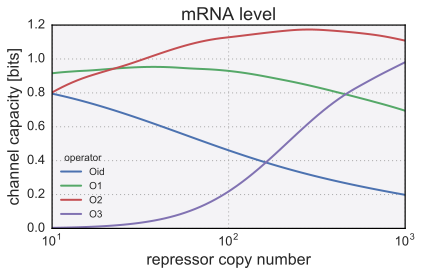

In [10]:
kon_operators = ['Oid', 'O1', 'O2', 'O3']
fig = plt.figure()
# Load the pickled data
for kon in kon_operators:
    df = pd.read_csv(outputdir + 'capacity_mRNA_expIPTG_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon)
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=1, title='operator')
plt.title('mRNA level')
plt.tight_layout()
plt.savefig(figdir + 'channel_cap_operators_mRNA.pdf')

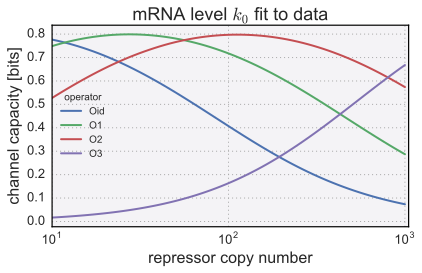

In [15]:
kon_operators = ['Oid', 'O1', 'O2', 'O3']
fig = plt.figure()
# Load the pickled data
for kon in kon_operators:
    df = pd.read_csv(outputdir + 'new_capacity_mRNA_expIPTG_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df.repressors, df.channel_capacity, label=kon)
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.legend(loc=0, ncol=1, title='operator')
plt.title('mRNA level $k_0$ fit to data')
plt.margins(0.05)
plt.tight_layout()

## Channel capacity at the protein level

For the protein range since the calculations are extremely slow we will build the transition matrix "manually" paralellizing the computation and making sure that the distributions are indeed normalized.

Let's first test it with a single operator and a single repressor copy number

In [53]:
prot_params = dict(ka=0.21, ki=0.00087, omega=np.exp(-4.5),
                   kon=chann_cap.kon_fn(-13.9),
                   k0=k0,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=100)
prot_params['rep'] = 10 * 1.66
prot_params['kon'] = chann_cap.kon_fn(-13.9)

# Define the protein blocks
prot_grid = np.reshape(np.arange(0, 4000), [-1, 250])

# Define the concentrations to evaluate
C_grid = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3
# C_grid = np.array([0, 50, 500, 5000]) / 1E3

lnp_list = list()
# loop through the concentrations
for c in C_grid:
    print(c)
    # define a function to run in parallel the computation
    def lnp_parallel(r):
        lnp = chann_cap.log_p_p_mid_C(C=c, protein=r, **prot_params)
        return lnp
    lnp_list.append(Parallel(n_jobs=7)(delayed(lnp_parallel)(r) \
                                       for r in prot_grid))

0.0
0.001
0.005
0.01
0.025
0.05
0.075
0.1
0.25
0.5
1.0
5.0


Take only enough entries to make the distribution normalized

In [114]:
# Initialize transition matrix
QmC = np.zeros([prot_grid.size, len(C_grid)])
for i, lnp in enumerate(lnp_list):
    # Initialize the matrix of zeros where the normalized distribution will live
    p_norm = np.zeros_like(lnp)
    p = np.exp(lnp)

    # Compute the cumulative sum of the protein copy number
    p_sum = np.cumsum(np.sum(p, axis=1))

    # Find the first block that is already normalized given the tolerance value
    norm_idx = np.where((p_sum <= 1 + 1E-5) & (p_sum >= 1 - 1E-5))[0][-1]

    # add all the probability values of these blocks to our matrix
    p_norm[0:norm_idx, :] = p[0:norm_idx, :]
    QmC[:, i] = p_norm.ravel()
    
#Eliminate the protein counts on which for all concentrations the probability
#is always zero or very close to it
QmC = QmC[np.sum(QmC, axis=1) >= 1E-4, :]
print(QmC.shape)
# Check that all distributions for each concentration are normalized
print(np.sum(QmC, axis=0))

(1868, 12)
[ 0.99931923  0.99956922  0.99999647  1.          0.99999999  0.99998308
  0.99987639  0.99972564  0.99920886  0.99899592  0.99889386  0.99881773]


In [115]:
Il, pC, loop_count = channel_capacity(QmC.T, 1E-10)

print('Regular BA algorithm')
print('Mutual info:', Il, ' bits')
print('Input distribution:', pC)
print('Iterations:', loop_count)

Regular BA algorithm
Mutual info: 1.77738508418  bits
Input distribution: [  2.56450414e-01   5.69414403e-28   0.00000000e+00   2.30434936e-01
   2.27487212e-01   3.30777672e-02   1.12835527e-63   4.06521497e-76
   4.84747136e-41   1.00327877e-19   3.23212908e-09   2.52549667e-01]
Iterations: 2312


In [16]:
# Define the concentrations to evaluate
C_grid = np.array([0, 1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000]) / 1E3

# Define the protein blocks to evaluate in parallel
prot_grid = np.reshape(np.arange(0, 2250), [-1, 250])

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(1, 3, 70)

# Protein parameters
prot_params = dict(ka=0.199, ki=0.00064, omega=np.exp(-4.5),
                   k0=0.0000023,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=100)
# Rate constants
kon_array = [chann_cap.kon_fn(-15.3, prot_params['k0']), 
             chann_cap.kon_fn(-13.9, prot_params['k0']), 
             chann_cap.kon_fn(-9.7, prot_params['k0'])]
kon_operators = ['O1', 'O2', 'O3']

compute_capacity = True
if compute_capacity:
    for i, kon in enumerate(kon_array):
        print(kon_operators[i])
        # initialize list to save the channel capacities
        chan_cap = list()
        prot_params['kon'] = kon
        for r in R_array:
            print('Repressor = {:0.2f}'.format(r))
            prot_params['rep'] = r * 1.66
            # -- Parallel computation of distribution -- #
            lnp_list = list()
            # loop through the concentrations
            for c in C_grid:
                print(c)
                # define a function to run in parallel the computation
                def lnp_parallel(p):
                    lnp = chann_cap.log_p_p_mid_C(C=c, protein=p, **prot_params)
                    return lnp
                lnp_list.append(Parallel(n_jobs=7)(delayed(lnp_parallel)(p) \
                                                   for p in prot_grid))
            # -- Building and cleaning the transition matrix -- #
            # Initialize transition matrix
            QmC = np.zeros([prot_grid.size, len(C_grid)])
            for k, lnp in enumerate(lnp_list):
                # Initialize the matrix of zeros where the normalized
                # distribution will live
                p_norm = np.zeros_like(lnp)
                p = np.exp(lnp)
                # Compute the cumulative sum of the protein copy number
                p_sum = np.cumsum(np.sum(p, axis=1))
                # Find the first block that is already normalized given 
                # the tolerance value
                norm_idx = np.where((p_sum <= 1 + 1E-5) & \
                                    (p_sum >= 1 - 1E-5))[0][-1]
                # add all the probability values of these blocks to our matrix
                p_norm[0:norm_idx, :] = p[0:norm_idx, :]
                QmC[:, k] = p_norm.ravel()
            # Eliminate the protein counts on which for all concentrations 
            # the probability is always zero or very close to it
            QmC = QmC[np.sum(QmC, axis=1) >= 1E-4, :]
            # Check that all distributions for each concentration are normalized
            print(np.sum(QmC, axis=0))
            # Compute the channel capacity for the transition matrix QmC
            Il, pC, loop_count = channel_capacity(QmC.T, 1E-6)
            chan_cap.append(Il)
            print('Channel capacity = {:0.2f} bits'.format(Il))
        # -- Saving outcome -- #
        # Save channel capacity and repressor copy number into a DataFrame
        df = pd.DataFrame(np.vstack([np.array(chan_cap), R_array]).T,
             columns=['channel_capacity', 'repressors'])
        # Append the values of the parameters to the DataFrame to make it tidy
        param_df = pd.DataFrame(np.tile(\
                          np.array([val for (key,val) in prot_params.items()]),
                          (len(R_array), 1)), 
                          columns=prot_params.keys())
        df = pd.concat([df, param_df], axis=1)
        df.to_csv(outputdir + 'capacity_protein_expIPTG_' + \
                  kon_operators[i] + '_noise_fit.csv')

O1
Repressor = 10.00
0.0
0.001
0.005
0.01
0.025
0.05
0.075
0.1
0.25
0.5
1.0
5.0
[ 0.99101467  0.99098816  0.990933    0.99137998  0.99376477  0.99619377
  0.99720822  0.99770082  0.99845918  0.99865059  0.99873119  0.99878776]
Channel capacity = 0.80 bits
Repressor = 10.69
0.0
0.001
0.005
0.01
0.025
0.05
0.075
0.1
0.25
0.5
1.0
5.0
[ 0.99144785  0.9914176   0.99132288  0.99169332  0.99388001  0.99620643
  0.99720354  0.99769316  0.99845395  0.99864733  0.99872892  0.99878625]
Channel capacity = 0.81 bits
Repressor = 11.43
0.0
0.001
0.005
0.01
0.025
0.05
0.075
0.1
0.25
0.5
1.0
5.0
[ 0.99187893  0.99184527  0.99171423  0.99201349  0.99400842  0.9962271
  0.99720345  0.99768847  0.9984495   0.99864438  0.99872678  0.99878474]
Channel capacity = 0.81 bits
Repressor = 12.22
0.0
0.001
0.005
0.01
0.025
0.05
0.075
0.1
0.25
0.5
1.0
5.0
[ 0.99232539  0.99228869  0.99212452  0.99235687  0.99416217  0.99626319
  0.99721293  0.99769044  0.99844739  0.99864276  0.99872555  0.99878386]
Channel capacit

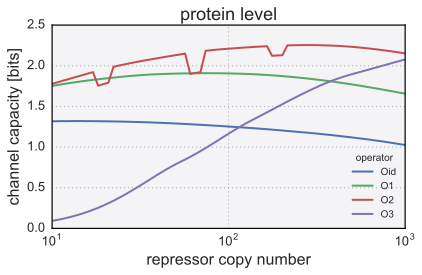

In [3]:
kon_operators = ['Oid', 'O1', 'O2', 'O3']
fig = plt.figure()
# Load the pickled data
for kon in kon_operators:
    df_prot = pd.read_csv(outputdir + 'capacity_protein_expIPTG_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df_prot.repressors, df_prot.channel_capacity, 
             label=kon)
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.title('protein level')
plt.xscale('log')
plt.legend(loc=0, ncol=1, title='operator')
plt.tight_layout()

Despite some obvious numrical errors in calculating O2 the trend looks remarkably similar to the mRNA level.

But notice that all the values are much higher than for the mRNA level! To see that, let's plot them together.

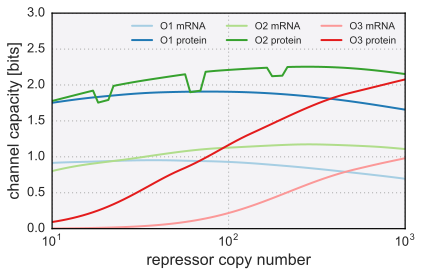

In [10]:
kon_operators = ['O1', 'O2', 'O3']
# colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)
colors = sns.color_palette('Paired', len(kon_operators) * 2)
fig = plt.figure()
# Load the pickled data
for i, kon in enumerate(kon_operators):
    df_mRNA = pd.read_csv(outputdir + 'capacity_mRNA_expIPTG_' + kon + '.csv')
    df_prot = pd.read_csv(outputdir + 'capacity_protein_expIPTG_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df_mRNA.repressors, df_mRNA.channel_capacity, label=kon + ' mRNA',
             color=colors[i * 2])
    plt.plot(df_prot.repressors, df_prot.channel_capacity, 
             label=kon + ' protein', linestyle='-',
             color=colors[i * 2 + 1])
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel('channel capacity [bits]')
plt.xscale('log')
plt.ylim([0, 3.0])
plt.legend(loc=0, ncol=3)
plt.tight_layout()
plt.savefig(figdir + 'chancap_mRNA_protein_compraison.pdf')

Let's try ploting the ratio of these channel capacities instead

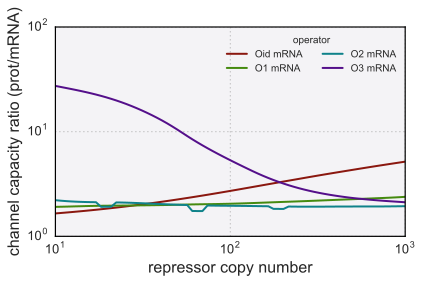

In [14]:
kon_operators = ['Oid', 'O1', 'O2', 'O3']
colors = sns.hls_palette(len(kon_operators), l=.3, s=.8)
fig = plt.figure()
# Load the pickled data
for i, kon in enumerate(kon_operators):
    df_mRNA = pd.read_csv(outputdir + 'capacity_mRNA_expIPTG_' + kon + '.csv')
    df_prot = pd.read_csv(outputdir + 'capacity_protein_expIPTG_' + kon + '.csv')
    # plot the channel capacity
    plt.plot(df_mRNA.repressors, 
             df_prot.channel_capacity / df_mRNA.channel_capacity, 
             label=kon + ' mRNA', color=colors[i])
# format the plot
plt.xlabel('repressor copy number')
plt.ylabel(r'channel capacity ratio (prot/mRNA)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=0, ncol=2, title='operator')
plt.tight_layout()

## Computing the capacity with linear-scale concentrations
### [0 mM, 5mM]

In [5]:
C_grid = np.linspace(0, 5, 150)
# mRNA_grid = np.linspace(0, 15.7 * 1.7, 75)
mRNA_grid = np.linspace(0, 25)

mastereq_param = dict(rep=100, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=50)

In [6]:
Il, pC = channel_capacity(C=C_grid, 
                          mRNA=mRNA_grid,
                          logPmC_fun=chann_cap.log_p_m_mid_C,
                          param=mastereq_param, epsilon=1E-4)

print('Channel capacity:', Il, 'bits')

Channel capacity: 0.642909484124 bits


In [15]:
C_grid = np.linspace(0, 5, 100)
mRNA_grid = np.arange(0, 100)

mastereq_param = dict(rep=10, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_capacity = True 
if compute_capacity:
# define a function to run in parallel the computation
    def capacity_parallel(r):
        mastereq_param['rep'] = r
        return channel_capacity(C=C_grid, 
                                mRNA=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_C,
                                param=mastereq_param, epsilon=1E-4,
                                info=1E5)[0]
    chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
    pklfile = open(outputdir + 'capacity_linear_0mM_5mM.pkl', 'wb')
    pickle.dump(chan_cap, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(C_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)
    pickle.dump(mastereq_param, pklfile)
    pklfile.close()

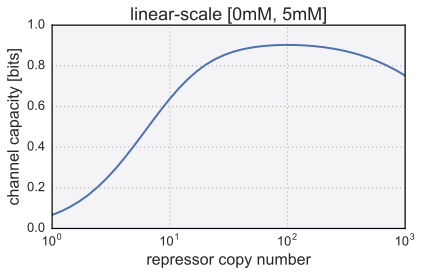

In [16]:
# Load the pickled data
with open(outputdir + 'capacity_linear_0mM_5mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    chan_cap = unpickler.load()
    R_array = unpickler.load()

with sns.axes_style('darkgrid', rc=rc):
    plt.plot(R_array, chan_cap)
    plt.xlabel('repressor copy number')
    plt.ylabel('channel capacity [bits]')
    plt.title('linear-scale [0mM, 5mM]')
    plt.xscale('log')
plt.tight_layout()
plt.savefig(figdir + 'channelcap_vs_R.pdf')

### Plotting the capacity distributions

In [13]:
C_grid = np.linspace(0, 5, 300)
mRNA_grid = np.linspace(0, 100, 201)

mastereq_param = dict(rep=10, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# define the array of repressor copy numbers to evaluate the function in
R_array = [10, 100, 1000]

compute_capacity = True
if compute_capacity:
# define a function to run in parallel the computation
    def capacity_parallel(r):
        mastereq_param['rep'] = r
        return list(channel_capacity(C=C_grid, 
                                mRNA=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_C,
                                param=mastereq_param, epsilon=1E-4,
                                info=1E5))
    chann_list = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
    pklfile = open(outputdir + 'capacity_pC_linear_0mM_5mM.pkl', 'wb')
    pickle.dump(chann_list, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(C_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)
    pickle.dump(mastereq_param, pklfile)
    pklfile.close()

0 Iu - Il =  1
0 Iu - Il =  1
0 Iu - Il =  1


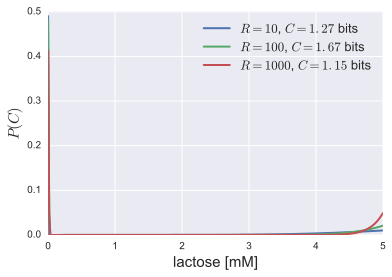

In [40]:
# Load the pickled data
with open(outputdir + 'capacity_pC_linear_0mM_5mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    chann_list = unpickler.load()
    R_array = unpickler.load()
    C_grid = unpickler.load()

for i, c in enumerate(chann_list):
    _ = plt.plot(C_grid, c[1],
    label=r'$R = {0:0.0f}$, $C = {1:0.2f}$ bits'.format(R_array[i], c[0]))
plt.xlabel('lactose [mM]')
plt.ylabel(r'$P(C)$')
plt.legend(loc=0, fontsize=13)

## Computing the capacity with log-scale concentrations
### [$10^{-6}$ mM, $10^{0}$mM]

In [6]:
logC_grid = np.linspace(-6, 0, 150)
mRNA_grid = np.arange(0, 100)

mastereq_param = dict(rep=10, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# define the array of repressor copy numbers to evaluate the function in
R_array = np.logspace(0, 3, 40)

compute_capacity = True
if compute_capacity:
# define a function to run in parallel the computation
    def capacity_parallel(r):
        mastereq_param['rep'] = r
        return channel_capacity(C=logC_grid, 
                                mRNA=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_logC,
                                param=mastereq_param, epsilon=1E-4,
                                info=1E5)[0]
    chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
    # pickle the output
    pklfile = open(outputdir + 'capacity_log_1E-6mM_1mM.pkl', 'wb')
    pickle.dump(chan_cap, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)
    pickle.dump(mastereq_param, pklfile)
    pklfile.close()

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/razo/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/Users/razo/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x10112d420, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/razo/.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10112d420, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/razo/.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-01T10:03:04.068893', 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'session': '8EC589C96F16497DB33F532347C43F7A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8EC589C96F16497DB33F532347C43F7A']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-01T10:03:04.068893', 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'session': '8EC589C96F16497DB33F532347C43F7A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8EC589C96F16497DB33F532347C43F7A'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-08-01T10:03:04.068893', 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'session': '8EC589C96F16497DB33F532347C43F7A', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'D95DE166D97C4824811EEDE0AA8D0272', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()', store_history=True, silent=False, shell_futures=True)
   2700                 self.displayhook.exec_result = result
   2701 
   2702                 # Execute the user code
   2703                 interactivity = "none" if silent else self.ast_node_interactivity
   2704                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2705                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2706                 
   2707                 self.last_execution_succeeded = not has_raised
   2708 
   2709                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.If object>], cell_name='<ipython-input-6-22dd8d0602cd>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10abefda0, execution_..._before_exec=None error_in_exec=None result=None>)
   2804 
   2805         try:
   2806             for i, node in enumerate(to_run_exec):
   2807                 mod = ast.Module([node])
   2808                 code = compiler(mod, cell_name, "exec")
-> 2809                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11ac53ed0, file "<ipython-input-6-22dd8d0602cd>", line 11>
        result = <ExecutionResult object at 10abefda0, execution_..._before_exec=None error_in_exec=None result=None>
   2810                     return True
   2811 
   2812             for i, node in enumerate(to_run_interactive):
   2813                 mod = ast.Interactive([node])

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11ac53ed0, file "<ipython-input-6-22dd8d0602cd>", line 11>, result=<ExecutionResult object at 10abefda0, execution_..._before_exec=None error_in_exec=None result=None>)
   2864         outflag = 1  # happens in more places, so it's easier as default
   2865         try:
   2866             try:
   2867                 self.hooks.pre_run_code_hook()
   2868                 #rprint('Running code', repr(code_obj)) # dbg
-> 2869                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11ac53ed0, file "<ipython-input-6-22dd8d0602cd>", line 11>
        self.user_global_ns = {'Il': 0.16163186082364497, 'In': ['', "# Our numerical workhorses\nimport numpy as np\nfr...lgorithm_channel_capacity/'\ntmpdir = '../../tmp/'", 'def channel_capacity_test(QmC, epsilon=1E-3):\n  ...Il = Il / np.log(2)\n    return Il, pC, loop_count', "QmC = np.array([[0.7, 0.1], [0.2, 0.2], [0.1, 0....tribution:', pC)\nprint('Iterations:', loop_count)", "QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05...tribution:', pC)\nprint('Iterations:', loop_count)", 'def channel_capacity(C, m, logPmC_fun, param, ep...to bits\n    Il = Il / np.log(2)\n    return Il, pC', 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'QmC': array([[ 0.6 ,  0.7 ,  0.5 ],
       [ 0.3 ,  0.1 ,  0.05],
       [ 0.1 ,  0.2 ,  0.45]]), 'R_array': array([    1.        ,     1.19377664,     1.425...   701.70382867,   837.67764007,  1000.        ]), '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, ...}
        self.user_ns = {'Il': 0.16163186082364497, 'In': ['', "# Our numerical workhorses\nimport numpy as np\nfr...lgorithm_channel_capacity/'\ntmpdir = '../../tmp/'", 'def channel_capacity_test(QmC, epsilon=1E-3):\n  ...Il = Il / np.log(2)\n    return Il, pC, loop_count', "QmC = np.array([[0.7, 0.1], [0.2, 0.2], [0.1, 0....tribution:', pC)\nprint('Iterations:', loop_count)", "QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05...tribution:', pC)\nprint('Iterations:', loop_count)", 'def channel_capacity(C, m, logPmC_fun, param, ep...to bits\n    Il = Il / np.log(2)\n    return Il, pC', 'logC_grid = np.linspace(-6, 0, 150)\nmRNA_grid = ...dump(mastereq_param, pklfile)\n    pklfile.close()'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'QmC': array([[ 0.6 ,  0.7 ,  0.5 ],
       [ 0.3 ,  0.1 ,  0.05],
       [ 0.1 ,  0.2 ,  0.45]]), 'R_array': array([    1.        ,     1.19377664,     1.425...   701.70382867,   837.67764007,  1000.        ]), '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, ...}
   2870             finally:
   2871                 # Reset our crash handler in place
   2872                 sys.excepthook = old_excepthook
   2873         except SystemExit as e:

...........................................................................
/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/<ipython-input-6-22dd8d0602cd> in <module>()
     15         return channel_capacity(C=logC_grid, 
     16                                 mRNA=mRNA_grid,
     17                                 logPmC_fun=evo_utils.log_p_m_mid_logC,
     18                                 param=mastereq_param, epsilon=1E-4,
     19                                 info=1E5)[0]
---> 20     chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
     21     # pickle the output
     22     pklfile = open(outputdir + 'capacity_log_1E-6mM_1mM.pkl', 'wb')
     23     pickle.dump(chan_cap, pklfile)
     24     pickle.dump(R_array, pklfile)

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=6), iterable=<generator object <genexpr>>)
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=6)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Mon Aug  1 10:03:04 2016
PID: 2101                     Python 3.5.2: /Users/razo/anaconda/bin/python
...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function capacity_parallel>, (1.0,), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/razo/anaconda/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function capacity_parallel>
        args = (1.0,)
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/razo/Documents/PhD/evolution_bits/src/continuous_game/<ipython-input-6-22dd8d0602cd> in capacity_parallel(r=1.0)
     14         mastereq_param['rep'] = r
     15         return channel_capacity(C=logC_grid, 
     16                                 mRNA=mRNA_grid,
     17                                 logPmC_fun=evo_utils.log_p_m_mid_logC,
     18                                 param=mastereq_param, epsilon=1E-4,
---> 19                                 info=1E5)[0]
     20     chan_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
     21     # pickle the output
     22     pklfile = open(outputdir + 'capacity_log_1E-6mM_1mM.pkl', 'wb')
     23     pickle.dump(chan_cap, pklfile)

TypeError: channel_capacity() got an unexpected keyword argument 'mRNA'
___________________________________________________________________________

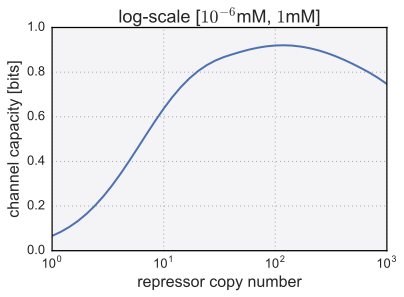

In [12]:
# Load the pickled data
with open(outputdir + 'capacity_log_1E-6mM_1mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    chan_cap = unpickler.load()
    R_array = unpickler.load()

with sns.axes_style(rc=rc):
    plt.plot(R_array, chan_cap)
    plt.xlabel('repressor copy number')
    plt.ylabel('channel capacity [bits]')
    plt.title('log-scale [$10^{-6}$mM, $1$mM]')
    plt.xscale('log')

In [33]:
logC_grid = np.linspace(-6, 1, 500)
mRNA_grid = np.linspace(0, 100, 201)

mastereq_param = dict(rep=10, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# define the array of repressor copy numbers to evaluate the function in
R_array = [10, 100, 1000]

compute_capacity = True
if compute_capacity:
# define a function to run in parallel the computation
    def capacity_parallel(r):
        mastereq_param['rep'] = r
        return list(channel_capacity(C=logC_grid, 
                                mRNA=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_logC,
                                param=mastereq_param, epsilon=1E-4,
                                info=1E5))
    chann_list = Parallel(n_jobs=6)(delayed(capacity_parallel)(r) for r in R_array)
    pklfile = open(outputdir + 'capacity_pC_log_1E-6mM_10mM.pkl', 'wb')
    pickle.dump(chann_list, pklfile)
    pickle.dump(R_array, pklfile)
    pickle.dump(logC_grid, pklfile)
    pickle.dump(mRNA_grid, pklfile)
    pickle.dump(mastereq_param, pklfile)
    pklfile.close()

0 Iu - Il =  1
0 Iu - Il =  1
0 Iu - Il =  1


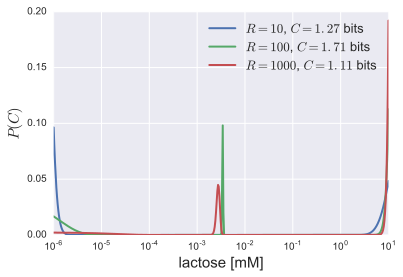

In [38]:
# Load the pickled data
with open(outputdir + 'capacity_pC_log_1E-6mM_10mM.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    chann_list = unpickler.load()
    R_array = unpickler.load()
    logC_grid = unpickler.load()

for i, c in enumerate(chann_list):
    _ = plt.plot(10**logC_grid, c[1], 
    label=r'$R = {0:0.0f}$, $C = {1:0.2f}$ bits'.format(R_array[i], c[0]))
plt.xlabel(r'lactose [mM]')
plt.ylabel(r'$P(C)$')
plt.xscale('log')
plt.legend(loc=0, fontsize=13)

# Computing channel capacities of random sets of parameters.

To test what are the different possible values of the channel capacity we will take a similar approach to the previous exploration of parameter space where we generate random sets of parameters and compute the channel capacity.

In [3]:
# master equation wild type parameters
mastereq_param = dict(rep=10, ki=0.0012, ka=0.015, omega=1.1, kon=0.0069, 
                      k0=2.7e-3, gamma=0.00284, r_gamma=15.7)

# define the parameter ranges
mastereq_range = dict(rep=[1, 1000],
                      ki=[1E-6, 1E-3],
                      ka=[1E-5, 1E-2],
                      omega=[0.05, 20],
                      kon=[0.0069 * 1E-1, 0.0069 * 1E1],
                      gamma=[1, 20],
                      r_gamma=[1, 15.7 * 1.7])

In [58]:
directory = outputdir + 'capacity_rnd_linear_0mM_5mM/'

# define how many points I want to generate on each file
npoints = 1000

run_simulation = False
if run_simulation:
    for loop in np.arange(72, 999):
        print('loop : ', loop)
        # define grid for simulation
        C_grid = np.linspace(0, 5, 100)
        mRNA_grid = np.linspace(0, 100, 201)
        
        # generate the random set of parameters
        df_param = chann_cap.rand_param_sets(mastereq_range, npoints, True)
        # add the parameter is not being modified
        df_param['k0'] = np.repeat(2.7e-3, df_param.shape[0])
        
        # compute the channel capacity in parallel
        def capacity_parallel(i):
            return channel_capacity(C=C_grid, 
                                mRNA=mRNA_grid,
                                logPmC_fun=chann_cap.log_p_m_mid_C,
                                param=df_param.ix[i].to_dict(),
                                epsilon=1E-3,
                                info=1E5)[0]
        chann_cap = Parallel(n_jobs=6)(delayed(capacity_parallel)(i) for i in \
                                   np.arange(len(df_param)))
        
        # add columns to pandas DataFrame and save in CSV
        df_param['channel_capacity'] = chann_cap
        df_param.to_csv(directory + \
        'capacity_rnd_linear_0mM_5mM_{0:03d}.csv'.format(loop), index=False)

(0, 2)

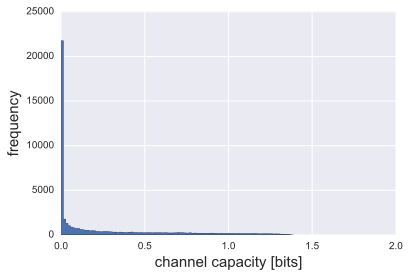

In [60]:
directory = outputdir + 'capacity_rnd_linear_0mM_5mM/'

# list files in directory
files = os.listdir(directory)

channel_cap_list = list()
for file in files:
    df_param = pd.read_csv(directory + file)
    channel_cap_list.append(df_param['channel_capacity'])
channel_cap_merged = np.array(list(itertools.chain(*channel_cap_list)))

_ = plt.hist(channel_cap_merged, bins = 100,
             # bins=np.round(np.sqrt(len(channel_cap_merged))),
             normed=False, histtype='stepfilled')
plt.xlabel('channel capacity [bits]')
plt.ylabel('frequency')
plt.xlim([0, 2])